<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

###Load Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [4]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [5]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [6]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [7]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

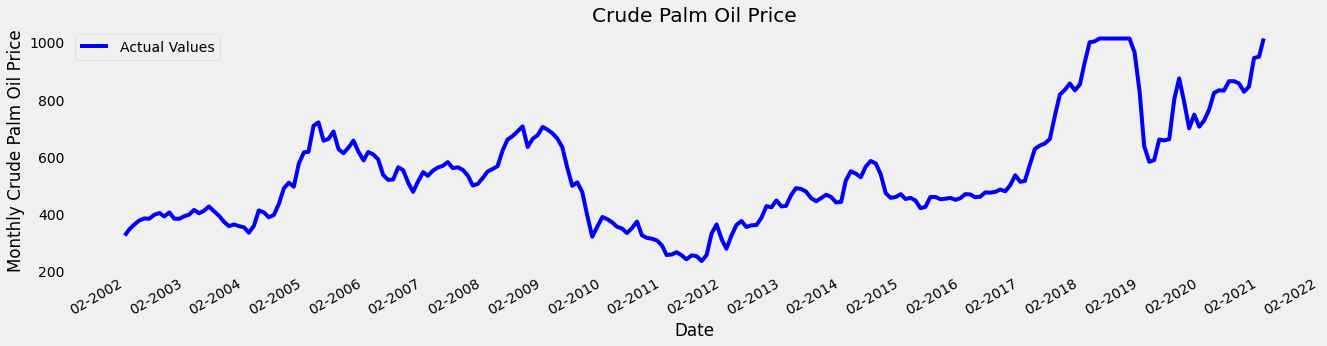

In [8]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [9]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

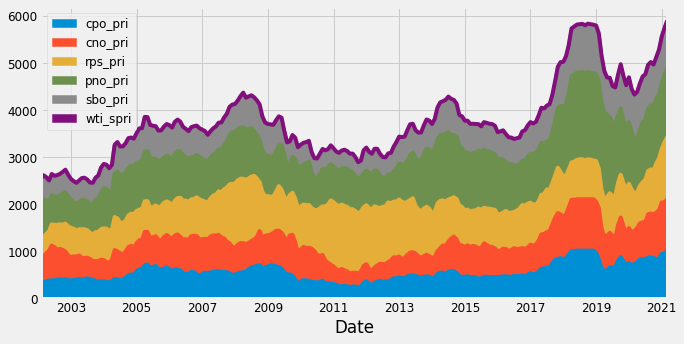

In [10]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [11]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 184
Test size: 46


###Plot Train Test Data

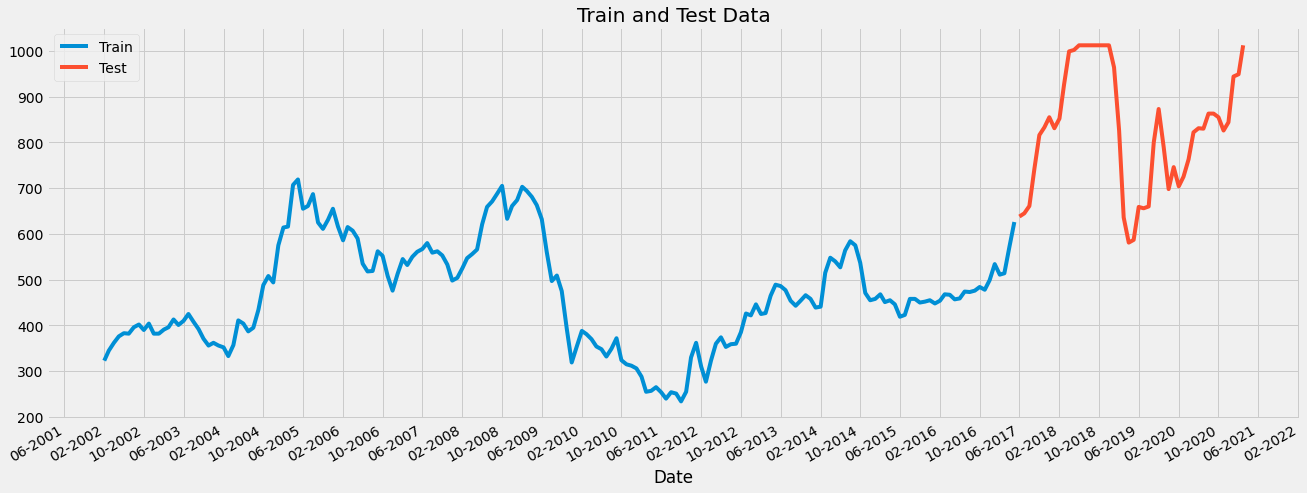

In [12]:
#Plotting data
plt.figure(figsize=(20,8))
plt.title("Train and Test Data")
plt.plot(train.index, train['cpo_pri'], label='Train')
plt.plot(test.index, test['cpo_pri'], label='Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=8))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [13]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

184 46


In [14]:
print(train.shape)
train.head()

(184, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [15]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,0.288625,0.013238,0.323766,0.432130,0.109026
2002-03-01,345.0,0.443124,0.005303,0.272101,0.472692,0.044200
2002-04-01,362.0,0.526316,0.000000,0.179104,0.427358,0.006514
2002-05-01,376.0,0.595925,0.004228,0.059701,0.370094,0.000000
2002-06-01,383.0,0.769100,0.042041,0.065442,0.339076,0.010236


In [16]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01    0.183505
2002-03-01    0.228866
2002-04-01    0.263918
2002-05-01    0.292784
2002-06-01    0.307216
Name: cpo_pri, dtype: float64

In [17]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2017-06-01,638.0,0.757216,0.455910,0.585121,0.979313,0.431141
2017-07-01,645.0,0.811545,0.517005,0.521619,1.021570,0.442463
2017-08-01,661.0,0.821732,0.485027,0.566257,1.031090,0.384150
2017-09-01,743.0,0.921902,0.482428,0.592618,1.113813,0.403381
2017-10-01,816.0,1.033956,0.507880,0.697371,1.197323,0.345068


In [18]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2017-06-01    0.832990
2017-07-01    0.847423
2017-08-01    0.880412
2017-09-01    1.049485
2017-10-01    1.200000
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [19]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(181, 3, 6) (181,)


In [ ]:
test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["Date"]).unstack().shift(3).stack()

###Create Model

In [20]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(50, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1))
cnn_model.compile(loss='mse', optimizer='adam')
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4,133
Trainable params: 4,133
Non-trainable params: 0
______________________________________________________

In [ ]:
'''
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2]))) #64,32, 16, 8 (best so far)
cnn_model.add(Dropout(0.1))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(4, activation='relu')) #32, 8,4
#cnn_model.add(Dropout(0.1))
cnn_model.add(tf.keras.layers.Dense(1))
#cnn_model.add(Dropout(0.25))
#Dropout(droprate)
cnn_model.compile(loss='mse', optimizer='adam')
cnn_model.summary()
'''

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 3, 8)              56        
                                                                 
 dropout_1 (Dropout)         (None, 3, 8)              0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 3, 8)             0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 24)                0         
                                                                 
 dense_6 (Dense)             (None, 4)                 100       
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                      

In [21]:
cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
6/6 [==============================] - 1s 37ms/step - loss: 0.3387 - val_loss: 0.9230
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0757 - val_loss: 0.1815
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0395 - val_loss: 0.0662
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0461 - val_loss: 0.0708
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0281 - val_loss: 0.1215
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0226 - val_loss: 0.1555
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0228 - val_loss: 0.1297
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0194 - val_loss: 0.0874
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0170 - val_loss: 0.0688
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 0.0680
Epoch 11/50
6/6 [=====================

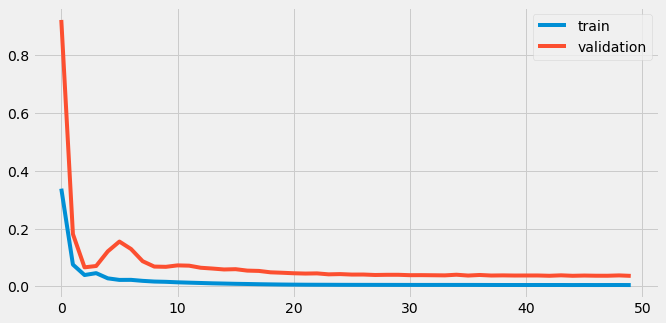

In [22]:
plt.plot(cnn_history.history['loss'], label='train')
plt.plot(cnn_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

###Predict the test data

In [23]:
y_pred = cnn_model.predict(X_test)
y_pred

array([[0.90850013],
       [0.9780321 ],
       [1.1136602 ],
       [1.2120684 ],
       [1.2471628 ],
       [1.2364918 ],
       [1.2980548 ],
       [1.3877238 ],
       [1.4703678 ],
       [1.5186017 ],
       [1.5253495 ],
       [1.5324407 ],
       [1.5362961 ],
       [1.5349725 ],
       [1.5366427 ],
       [1.5372729 ],
       [1.5350692 ],
       [1.5254475 ],
       [1.4620622 ],
       [1.2841241 ],
       [0.99564654],
       [0.77556515],
       [0.77446884],
       [0.84797156],
       [0.84583145],
       [0.9607157 ],
       [1.2185086 ],
       [1.2642909 ],
       [1.1876347 ],
       [1.0985794 ],
       [1.1064469 ],
       [1.0737722 ],
       [1.1342151 ],
       [1.2191147 ],
       [1.2516665 ],
       [1.2643464 ],
       [1.3181658 ],
       [1.3287544 ],
       [1.2355771 ],
       [1.2296741 ],
       [1.2634889 ],
       [1.3591549 ],
       [1.4277753 ]], dtype=float32)

###Inverse transformed data

Scale the data back to the original representation

In [24]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370. 354. 348.
  332. 349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254.
  251. 234. 255. 330. 362. 310. 277. 323. 360. 374. 353. 359. 360. 385.
  426. 422. 446. 425. 427. 465. 489. 486. 477. 454. 443. 454. 466. 458.
  439. 441. 515. 548. 540. 527. 564. 584. 575. 537. 471. 455. 458. 468.
  451. 455. 446. 419. 423. 458. 458. 450. 452. 455. 448. 454. 468. 467.
  457. 459. 474. 473. 476. 484. 478. 499. 534. 511. 514. 572. 626.]]
[[ 743.    816.    833.    855.    831.    852.    926.    999.   1

###Plot history, actual and predicted value

In [25]:
y_train_inv = y_train_inv.flatten()
y_train_inv
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 743.  ,  816.  ,  833.  ,  855.  ,  831.  ,  852.  ,  926.  ,
        999.  , 1002.  , 1012.25, 1012.25, 1012.25, 1012.25, 1012.25,
       1012.25, 1012.25,  964.  ,  826.  ,  636.  ,  581.  ,  587.  ,
        659.  ,  656.  ,  660.  ,  800.  ,  873.  ,  789.  ,  698.  ,
        746.  ,  704.  ,  725.  ,  763.  ,  822.  ,  831.  ,  830.  ,
        863.  ,  863.  ,  855.  ,  826.  ,  844.  ,  944.  ,  949.  ,
       1012.25])

In [26]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([674.62256, 708.3456 , 774.1252 , 821.8532 , 838.87396, 833.6985 ,
       863.5566 , 907.046  , 947.12836, 970.52185, 973.7945 , 977.23376,
       979.1037 , 978.4617 , 979.27167, 979.5774 , 978.5086 , 973.84204,
       943.10016, 856.8002 , 716.8886 , 610.1491 , 609.61743, 645.2662 ,
       644.2283 , 699.94714, 824.9767 , 847.1811 , 810.0028 , 766.811  ,
       770.6267 , 754.7795 , 784.0943 , 825.2706 , 841.0583 , 847.20795,
       873.31036, 878.44586, 833.2549 , 830.3919 , 846.7921 , 893.1901 ,
       926.471  ], dtype=float32)

###Plot Actual and Predicted Value 

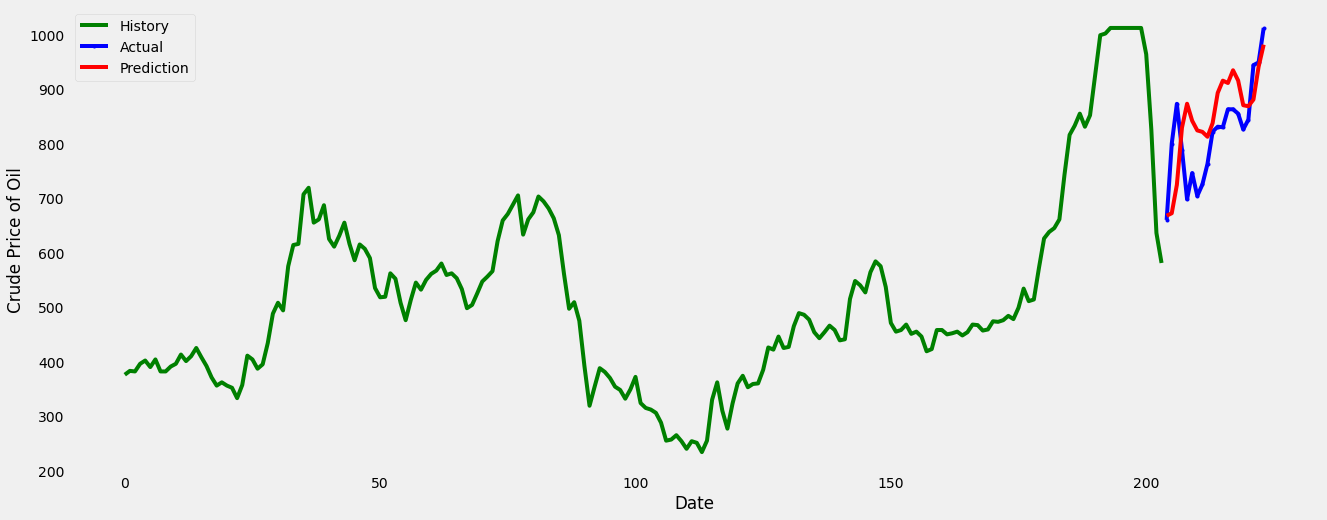

In [ ]:
plt.figure(figsize=(20,8))
plt.grid()
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Price of Oil')
plt.xlabel('Date')
plt.legend()
plt.show();

###Plot Actual and Predicted Value Zoomed-In

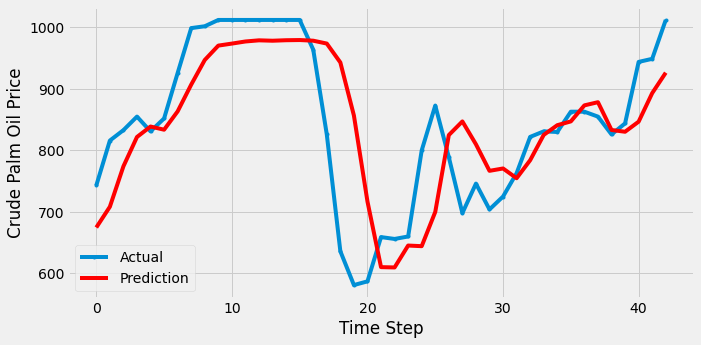

In [27]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
'''
plt.figure(figsize=(20,8))
plt.grid()
plt.plot(test_lag.index, y_test_inv, color = 'red',  label = 'Test')
plt.plot(test_lag.index,  y_pred_inv, color = 'blue',label = 'CNN Prediction')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['True Values', 'Predictions by Cnn', 'CNN Prediction'],loc='best')
plt.title('CNN Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
'''

###Evaluate CNN Model Accuracy

In [30]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)
print('EVS score of the CNN Model is:', EVS_cnn)

MAE value of the CNN Model is: 64.99848973473837
MDA value of the CNN Model is: 0.5476190476190477
MAPE value of the CNN Model is: 8.511253354988897
RMSE value of the CNN Model is: 92.7755067998982
MSE value of the CNN Model is: 8607.294661977956
EVS score of the CNN Model is: 0.46532428651183133


In [ ]:
'''
###Apply Grid Search
seed = 7
np.random.seed(seed)
print ("Regressor")
model = KerasRegressor(build_fn = create_model, verbose = 10)
init_mode_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation_mode_list = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
activation_mode_list_conv =  ['softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
optimizer_mode_list = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
batch_size_list = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(init_mode=init_mode_list, batch_size=batch_size_list, nb_epoch=epochs, activation_mode=activation_mode_list, optimizer_mode = optimizer_mode_list, activation_mode_conv =  activation_mode_list_conv)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
print ("Grid fit")
grid_result = grid.fit(np.asarray(input_train), np.array(output_train))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''

'\n###Apply Grid Search\nseed = 7\nnp.random.seed(seed)\nprint ("Regressor")\nmodel = KerasRegressor(build_fn = create_model, verbose = 10)\ninit_mode_list = [\'uniform\', \'lecun_uniform\', \'normal\', \'zero\', \'glorot_normal\', \'glorot_uniform\', \'he_normal\', \'he_uniform\']\nactivation_mode_list = [\'softmax\', \'softplus\', \'softsign\', \'relu\', \'tanh\', \'sigmoid\', \'hard_sigmoid\', \'linear\']\nactivation_mode_list_conv =  [\'softplus\', \'softsign\', \'relu\', \'tanh\', \'sigmoid\', \'hard_sigmoid\', \'linear\']\noptimizer_mode_list = [\'SGD\', \'RMSprop\', \'Adagrad\', \'Adadelta\', \'Adam\', \'Adamax\', \'Nadam\']\nbatch_size_list = [10, 20, 40, 60, 80, 100]\nepochs = [10, 50, 100]\nparam_grid = dict(init_mode=init_mode_list, batch_size=batch_size_list, nb_epoch=epochs, activation_mode=activation_mode_list, optimizer_mode = optimizer_mode_list, activation_mode_conv =  activation_mode_list_conv)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)\npr